In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
def numerify(var):
    """
    Cast an object as an int or float if possible. Otherwise return unmodified
    """
    
    if isinstance(var, str):
        try:
            var = int(var)

        except:
            try:
                var = float(var)
            except:
                pass
    else:
        pass
            
    return var

In [90]:
type(cleaned_esaxs)

pandas.core.frame.DataFrame

In [3]:
#write a nice data loader
#should return metadata as a dict, data in a pandas df


def read_1D_data(fp):
    """
    Read a 1D Xenocs data .dat file
    """
    metadata = {}
    q = []
    I = []
    sig = []
    header_count = 0

    in_data = False # flag for if we are read into data yet

    with open(fp, 'rt') as f:
        for line in f:
            if not in_data:
                if line[:2] == '##': #metadata section header 
                    header_count +=1
                    continue
                elif line[:2] == '# ':
                    items = line.split()
                    metadata[items[1]] = numerify(items[2])

                elif line[0] == 'q' and header_count == 2:
                    in_data = True
            elif in_data:
                vals = line.split()
                q.append(numerify(vals[0]))
                I.append(numerify(vals[1]))
                sig.append(numerify(vals[2]))


    data = pd.DataFrame({'q':q, 'I':I, 'sig':sig})
    
    return data, metadata
                

        

In [4]:
def find_ratio_peak(ratio_avg):
    """
    Find max value of ratio using max
    Returns index of peak
    """
    
    avg_copy = ratio_avg.copy()
    avg_copy[avg_copy == np.inf] = 0
    ind = np.nanargmax(avg_copy)
    
    return ind

## 2. Subtract background

In [5]:
def ratio_running_average(a, b, n_pts = 10):
    """
    Calculate the running average of the ratio of signal to background
    
    a - signal data. 1d array
    b - background data. 1d array
    """
    
    assert len(a) == len(b), 'a and b must have same number of elements'
    
    ratio = a/b
    
    running_average = np.convolve(ratio, np.ones(n_pts)/n_pts, mode = 'same')
    
    return running_average
    
    

In [6]:
def scale_data(data1, data2, scale_qmin, scale_qmax):
    """
    scale data2 onto data1 using a scale factor calculated from the difference in integrals of data1 and data2 over the range scale_qmin -> scale_qmax
    """

    # get yvals for each dataset
    inrange_data1 = data1[data1['q'].between(scale_qmin, scale_qmax, inclusive = 'both')]
    inrange_data2 = data2[data2['q'].between(scale_qmin, scale_qmax, inclusive = 'both')]

    assert np.isclose(inrange_data1['q'].iloc[0], inrange_data2['q'].iloc[0])
    assert np.isclose(inrange_data1['q'].iloc[-1], inrange_data2['q'].iloc[-1])


    x1 = inrange_data1['q'].to_numpy()
    x2 = inrange_data2['q'].to_numpy()
    y1 = inrange_data1['I'].to_numpy()
    y2 = inrange_data2['I'].to_numpy()
    #check for nans in y values

    #trapezoid rule integrate
    scale1 = np.trapz(y1, x1)/(x1[-1] - x1[0])
    scale2 = np.trapz(y2, x2)/(x2[-1] - x2[0])

    scale_factor = scale1/scale2


    # scale data2 with scale factor
    data2_out = data2.copy()

    data2_out['I'] = data2['I']*scale_factor

    return data2_out


In [7]:
def subtract_background(data, background, scale_background = False, scale_qmin = 1e-4, scale_qmax = 1e-3):

    # check that q values line up for everything
    assert np.isclose(data['q'].to_numpy(), background['q'].to_numpy()).all()
    # once we get fancier look into allowance for slop or interpolation options. For now throw out anything not compliant ^^
    
    if scale_background:
        background = scale_data(data, background, scale_qmin, scale_qmax)
        
    subtracted_I = data['I'] - background['I']

    subtracted_data = data.copy()

    subtracted_data['I'] = subtracted_I
    
    return subtracted_data

In [8]:
def select_valid_data(signal, background, lowq_thresh = 5, hiq_thresh = 5, hiq_avg_pts = 10):
    """
    Find the region of valid data in SAXS signal
    
    Considers the ratio of signal to background to identify regions with enough scattering to provide information
    
    Parameters:
    -----------
    signal (DataFrame): signal saxs data
    background (DataFrame): corresponding background
    lowq_thresh: multiplier threshold for low q limit. Signal must be low_thresh times larger than background to find low q limit
    hiq_thresh: threshold for hiq limit
    hiq_avg_pts: how many data points to take a running average over when considering thresholds.
    """

    assert len(signal) == len(background), 'Signal and background data sets need to have same number of data points'

    q = signal['q']

    lowq_lim = None
    hiq_lim = None

    last_n_ratios = []
    rolling_average_ratio = ratio_running_average(signal['I'], background['I'], n_pts = hiq_avg_pts)

    # need to find peak to engage hi-q limit finder
    ratio_peak_ind = find_ratio_peak(rolling_average_ratio)



    for i, ratio in enumerate(rolling_average_ratio):
        if ratio > lowq_thresh:
            if lowq_lim is None:
                lowq_lim = i


        if lowq_lim is not None:
            if i > ratio_peak_ind:
                if ratio < hiq_thresh:
                    if hiq_lim is None:
                        hiq_lim = i
                        break
                        
    if lowq_lim is None:
        raise AssertionError('Failed to find region of valid data (low q limit not found). Check that your sample scatters reasonably well')
    if hiq_lim is None:
        raise AssertionError('Failed to find region of valid data (low q limit not found). Check that your sample scatters reasonably well')
        
    if hiq_lim - lowq_lim < 30:
        raise AssertionError('Insufficient data points in q range with scattering. Check data quality')

    return lowq_lim, hiq_lim


In [9]:
def chop_subtract(signal, background, lowq_thresh = 5, hiq_thresh = 5, hiq_avg_pts = 10, scale = False):
    """
    wrapper function to handle subtraction and valid data selection 
    """
    assert np.isclose(signal['q'].to_numpy(), background['q'].to_numpy()).all()

    loq, hiq = select_valid_data(signal, background, lowq_thresh = lowq_thresh, hiq_thresh= hiq_thresh, hiq_avg_pts = hiq_avg_pts)

    subtracted_signal = subtract_background(signal, background, scale_background = False)

    chopped_subtracted = subtracted_signal.iloc[loq:hiq]

    return chopped_subtracted


In [10]:
#figure out range of data to keep 

## 3. Data merge

In [11]:
#1. Figure out 'good' range for each data

#low end: this is hard. probably use hard-coded qmin for now

#upper end: do some sort of noise quantification. Maybe max-min over last 3 data points < 5% of average value? 

# 2. determine overlapping range for the 2 data sets

#3. Looking within overlapping range, apply rules to figure something out

    # - slopes should match
    # - values should be close 
    
    

In [12]:
def splice_datasets(low_q_data, hi_q_data, low_q_limit, hi_q_limit, low_q_source = None, hi_q_source = None):
    """
    Splice together low_q_data and hi_q_data. At q<lo_q_limit, only low_q_data included. Above hi_q_limit, only hi_q_data included. Between lo_q and hi_q limits, both datasets included
    """
    low_q_include = low_q_data[low_q_data['q'] < hi_q_limit].copy()
    hi_q_include = hi_q_data[hi_q_data['q'] > low_q_limit].copy()

    if low_q_source is not None:
        low_q_include['source'] = low_q_source
    if hi_q_source is not None:
        hi_q_include['source'] = hi_q_source

    spliced_data = pd.concat([low_q_include, hi_q_include]).sort_values('q')

    return spliced_data


In [13]:
def find_overlap(data1, data2):
    """
    Returns the subset of data1 that has q values strictly enclosed by q range of data2
    """

    # Find the range of data1 that is entirely within data2

    data1_qmax = data1['q'].max()
    data1_qmin = data1['q'].min()

    data2_qmax = data2['q'].max()
    data2_qmin = data2['q'].min()

    data1_overlap = data1[data1['q'] > data2_qmin]
    data1_overlap = data1_overlap[data1_overlap['q'] < data2_qmax]

    return data1_overlap


In [14]:
def interpolate_on_q(target_data, modify_data):
    """
    Linearly interpolate data from modify_data onto q grid from target data 
    """

    interp_I = np.interp(target_data['q'], modify_data['q'], modify_data['I'])

    interp_result = pd.DataFrame({'q':target_data['q'], 'I':interp_I})
    
    return interp_result





In [15]:
# forward diff
def forward_difference(data):


    q = data['q']
    I = data['I']

    dI = np.diff(I)
    dq = np.diff(q)

    dIdq = dI/dq
    
    data = data[:-1].copy()
    data['dIdq'] = dIdq
    
    return data

In [16]:
def deriv_ratio(data1, data2):
    deriv1 = forward_difference(data1)
    deriv2 = forward_difference(data2)
    
    ratio = deriv1['dIdq']/deriv2['dIdq']
    
    return ratio

In [17]:
def noise_score(data, n_pts = 20):
    """
    Calculate a measure of noisiness in data by looking at ratio of data to n_pts local running average (backwards average here I think)
    """
    running_average = np.convolve(data['I'], np.ones(n_pts)/n_pts, mode = 'same')

    ratio_to_average = data['I']/running_average

    noise_score = abs(1-ratio_to_average)
    
    return noise_score 

In [18]:
def find_qlim_low(low_q_data, hi_q_data, val_threshold = 0.1, slope_threshold = 0.4):
    """
    Find the low q merge limit using combination of curve closeness and slope criteria 
    """
    slope_ratio = deriv_ratio(low_q_data, hi_q_data)
    val_ratio = ratio_running_average(low_q_data['I'], hi_q_data['I'])

    match_count = 0

    for q, val, slope in zip(low_q_data['q'][1:], val_ratio[1:], slope_ratio):

        if abs(1-val) < val_threshold:
            if abs(1-slope) < slope_threshold:
                match_count +=1

        if match_count == 3:
            # we've found limit
            return q
        
    raise AssertionError('Q low limit matching given criteria not found')




In [19]:
def find_qlim_hi(low_q_data, qlim_low, noise_threshold = 0.2, n_pts = 20):
    """
    Find the hi q merge limit using noise criteria on low q data 
    """
    
    noise_value = noise_score(low_q_data, n_pts = n_pts)

    for i, (q, noise) in enumerate(zip(low_q_data['q'], noise_value)):
        if i > n_pts: # need to avoid edge effects 
            if q > qlim_low:
                if noise > noise_threshold:
                    return q
                
    raise AssertionError('Q lim hi not found with given criteria')

In [20]:
def get_merge_limits(low_q_data, hi_q_data, val_threshold = 0.1, slope_threshold = 0.4, noise_threshold = 0.2, n_pts = 20):
    
    qlim_low = find_qlim_low(low_q_data, hi_q_data, val_threshold = val_threshold, slope_threshold = slope_threshold)
    qlim_hi = find_qlim_hi(low_q_data, qlim_low, noise_threshold = noise_threshold, n_pts = n_pts)
    
    return (qlim_low, qlim_hi)

In [63]:
def auto_merge(low_q_data, hi_q_data, low_q_source = None, hi_q_source = None, val_threshold = 0.2, slope_threshold = 0.4, noise_threshold = 0.25, n_pts = 20):
    """
    Wrapper function to handle merging tasks 
    
    Takes subtracted/chopped data 
    """
    
    low_q_overlap = find_overlap(low_q_data, hi_q_data)
    hi_q_overlap = find_overlap(hi_q_data, low_q_data)
    
    hi_q_interpolated = interpolate_on_q(low_q_overlap, hi_q_overlap)
    
    low_q_lim, hi_q_lim = get_merge_limits(low_q_overlap, hi_q_interpolated, val_threshold = val_threshold, slope_threshold = slope_threshold, noise_threshold = noise_threshold, n_pts = n_pts)
    
    print(f'low q merge lim: {low_q_lim}')
    print(f'hi q merge lim: {hi_q_lim}')
    
    spliced = splice_datasets(low_q_overlap, hi_q_overlap, low_q_lim, hi_q_lim, low_q_source, hi_q_source)
    
    merge_metadata = {'low_q_source':low_q_source, 'hi_q_source':hi_q_source, 'low_q_limit':low_q_lim, 'hi_q_limit':hi_q_lim, 'low_q_value_threshold':val_threshold, 'low_q_slope_threshold':slope_threshold, 'hi_q_noise_threshold':noise_threshold, 'averaging_n_pts':n_pts}
    
    return spliced, merge_metadata

## Run processing here 

In [66]:
esaxs_data, esaxs_metadata = read_1D_data('data/2023_11_2_position2Top/Data_0_00002.dat')
saxs_data, saxs_metadata = read_1D_data('data/2023_11_2_position2Top/Data_0_00016.dat')
maxs_data, maxs_metadata = read_1D_data('data/2023_11_2_position2Top/Data_0_00030.dat')

esaxs_bkg_data, esaxs_bkg_metadata = read_1D_data('data/2023_11_2_position4Top/Data_0_00012.dat')
saxs_bkg_data, saxs_bkg_metadata = read_1D_data('data/2023_11_2_position4Top/Data_0_00026.dat')
maxs_bkg_data, maxs_bkg_metadata = read_1D_data('data/2023_11_2_position4Top/Data_0_00040.dat')

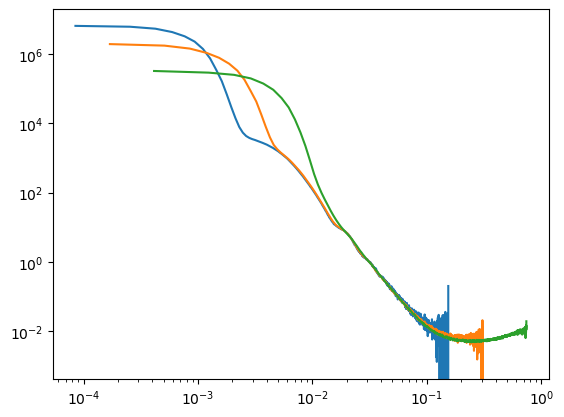

In [67]:
plt.loglog(esaxs_data['q'], esaxs_data['I'])
plt.loglog(saxs_data['q'], saxs_data['I'])
plt.loglog(maxs_data['q'], maxs_data['I'])

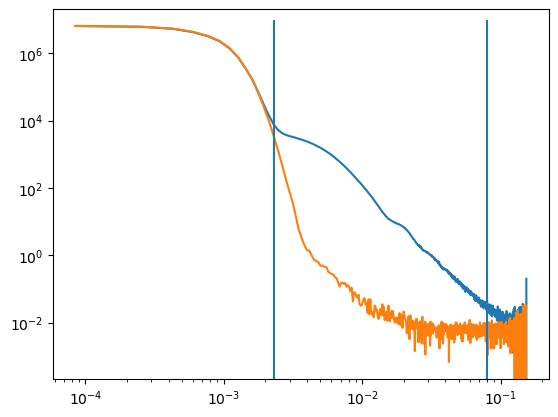

In [68]:
signal = esaxs_data
background = esaxs_bkg_data


loq, hiq = select_valid_data(signal, background, lowq_thresh = 5)

fig, ax = plt.subplots()



ax.loglog(signal['q'], signal['I'])
ax.loglog(background['q'], background['I'])


#ax1.loglog(esaxs_data['q'][1:], ratio_diff, c = 'g')
#ax1.loglog(esaxs_data['q'], rolling_average_ratio)

ax.vlines(signal['q'][loq], 0, 10e6)
ax.vlines(signal['q'][hiq], 0, 10e6)
#ax.vlines(q_peak, 0, 10e6, color = 'r')

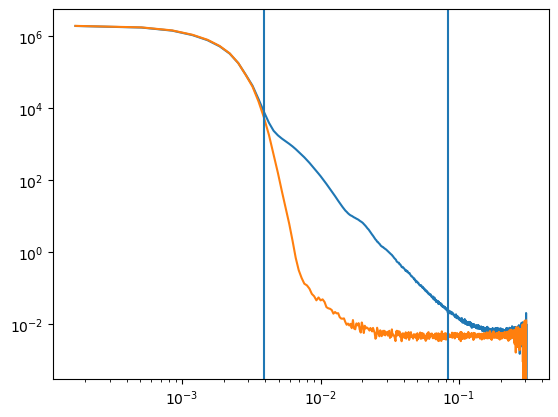

In [69]:
signal = saxs_data
background = saxs_bkg_data


loq, hiq = select_valid_data(signal, background, lowq_thresh = 5)

fig, ax = plt.subplots()



ax.loglog(signal['q'], signal['I'])
ax.loglog(background['q'], background['I'])


#ax1.loglog(esaxs_data['q'][1:], ratio_diff, c = 'g')
#ax1.loglog(esaxs_data['q'], rolling_average_ratio)

ax.vlines(signal['q'][loq], 0, 10e6)
ax.vlines(signal['q'][hiq], 0, 10e6)
#ax.vlines(q_peak, 0, 10e6, color = 'r')

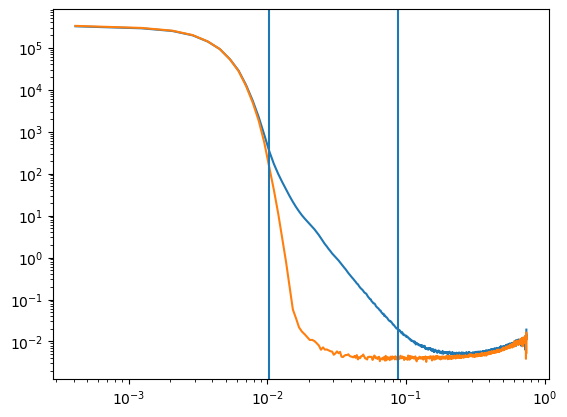

In [70]:
signal = maxs_data
background = maxs_bkg_data


loq, hiq = select_valid_data(signal, background, lowq_thresh = 5)

fig, ax = plt.subplots()



ax.loglog(signal['q'], signal['I'])
ax.loglog(background['q'], background['I'])


#ax1.loglog(esaxs_data['q'][1:], ratio_diff, c = 'g')
#ax1.loglog(esaxs_data['q'], rolling_average_ratio)

ax.vlines(signal['q'][loq], 0, 10e6)
ax.vlines(signal['q'][hiq], 0, 10e6)
#ax.vlines(q_peak, 0, 10e6, color = 'r')

In [71]:
loq

12

In [72]:
loq

12

In [73]:
cleaned_esaxs = chop_subtract(esaxs_data, esaxs_bkg_data)
cleaned_saxs = chop_subtract(saxs_data, saxs_bkg_data)
cleaned_maxs = chop_subtract(maxs_data, maxs_bkg_data)

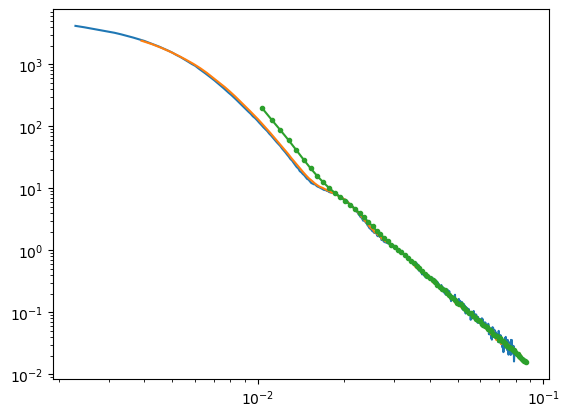

In [74]:
plt.loglog(cleaned_esaxs['q'], cleaned_esaxs['I'])
plt.loglog(cleaned_saxs['q'], cleaned_saxs['I'])
plt.loglog(cleaned_maxs['q'], cleaned_maxs['I'], marker = '.')

In [75]:
low_q_data = cleaned_esaxs
hi_q_data = cleaned_saxs

low_q_source = None
hi_q_source = None
val_threshold = 0.2
slope_threshold = 0.4
noise_threshold = 0.25
n_pts = 20

low_q_overlap = find_overlap(low_q_data, hi_q_data)
hi_q_overlap = find_overlap(hi_q_data, low_q_data)

hi_q_interpolated = interpolate_on_q(low_q_overlap, hi_q_overlap)

low_q_lim, hi_q_lim = get_merge_limits(low_q_overlap, hi_q_interpolated, val_threshold = val_threshold, slope_threshold = slope_threshold, noise_threshold = noise_threshold, n_pts = n_pts)

print(f'low q merge lim: {low_q_lim}')
print(f'hi q merge lim: {hi_q_lim}')

spliced = splice_datasets(low_q_overlap, hi_q_overlap, low_q_lim, hi_q_lim, low_q_source, hi_q_source)

low q merge lim: 0.00483904983326836
hi q merge lim: 0.06596388983244765


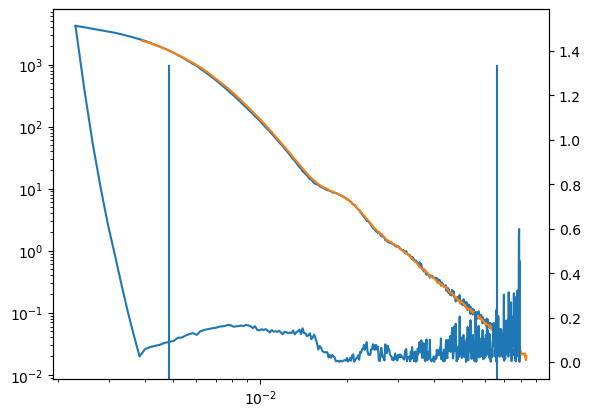

In [76]:

fig, ax = plt.subplots()

ax.loglog(cleaned_esaxs['q'], cleaned_esaxs['I'])
ax.loglog(cleaned_saxs['q'], cleaned_saxs['I'])
ax.vlines(low_q_lim, 0, 1e3)
ax.vlines(hi_q_lim, 0, 1e3)

ax1 = ax.twinx()

noise = noise_score(cleaned_esaxs, n_pts= n_pts)

ax1.semilogx(cleaned_esaxs['q'], noise)

In [78]:
merged1, merge_metadata_1 = auto_merge(cleaned_esaxs, cleaned_saxs, 'esaxs', 'saxs')
fullmerge, merge_metadata_2 = auto_merge(merged1, maxs_data, hi_q_source = 'maxs')


low q merge lim: 0.00483904983326836
hi q merge lim: 0.06596388983244765
low q merge lim: 0.017573391499764047
hi q merge lim: 0.07759467461926646


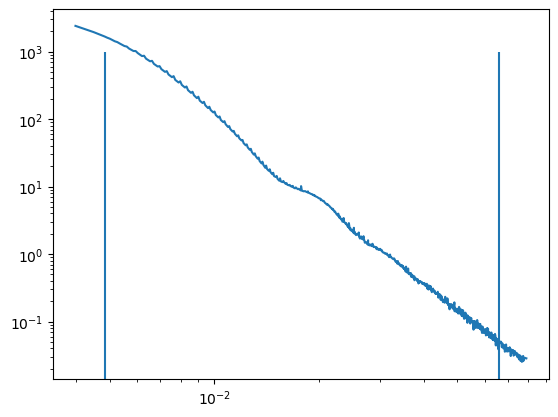

In [79]:
plt.loglog(fullmerge['q'], fullmerge['I'])
plt.vlines(low_q_lim, 0, 1e3)
plt.vlines(hi_q_lim, 0, 1e3)

In [87]:
def write_dat(data, metadata, fp):

    with open(fp, 'wt') as f:
        f.write('#'*80 + '\n')
        for key, val in metadata.items():
            f.write('# ' + str(key) + ' '*(32 - len(str(key))) + str(val) + '\n')
        f.write('#'*80 + '\n')
        f.write('q(A-1)                    I(q)                      Sig(q) \n')                    
        for i, row in data.iterrows():
            q = str(row['q'])
            i = str(row['I'])
            sig = str(row['sig'])
            f.write(q + ' '*(26 - len(q)) + i + ' '*(26 - len(i)) + sig + '\n') 

    

    
    

In [84]:
combined_metadata = {f'merge1_{key}':val for key, val in merge_metadata_1.items()}

for key, val in merge_metadata_2.items():
    combined_metadata[f'merge2_{str(key)}'] = val


In [88]:
write_dat(fullmerge, combined_metadata, 'testcase1_merged.dat')

In [59]:
str(q)

'0.07895300590363'

In [60]:
len('8.489561110997124e-05     ')#7248137.210298583         1490.3834240522779

26

In [61]:
len('7248137.210298583         ')

26